In [68]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd
from keras.utils.np_utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from keras.datasets import mnist
import itertools
plt.style.use('dark_background')

In [69]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [70]:
train_images.shape

(60000, 28, 28)

Randomly sampling a subset of the data, to make the combinations more tractable. 

(28, 28)


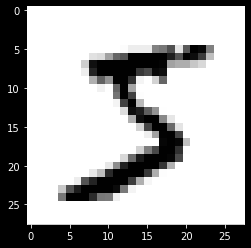

In [71]:
image_A = train_images[0]
print(image_A.shape)
plt.imshow(image_A, cmap = plt.cm.binary)

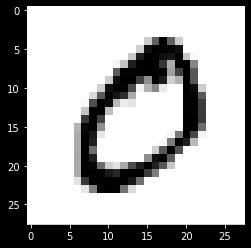

In [72]:
image_B = train_images[1]
plt.imshow(image_B, cmap = plt.cm.binary)

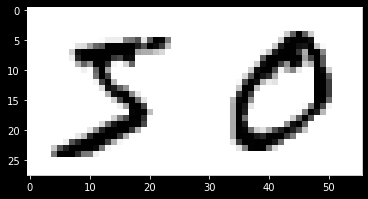

In [73]:
images_A_and_B = np.hstack((image_A, image_B))
plt.imshow(images_A_and_B, cmap = plt.cm.binary)

In [74]:
# Create mini training set so that it's not too computationally intensive
sample_size = 40000
X_train, X_val, y_train, y_val = train_images[:sample_size], train_images[sample_size:sample_size*2],  train_labels[:sample_size], train_labels[sample_size:sample_size*2]

In [75]:
X_train.shape

(40000, 28, 28)

In [76]:
fold = X_train.shape[0]//2
X_train_A, X_train_B, y_train_A, y_train_B = X_train[:fold], X_train[fold:], y_train[fold:], y_train[:fold]

val_fold = X_val.shape[0]//2
X_val_A, X_val_B, y_val_A, y_val_B = X_val[:val_fold], X_val[val_fold:], y_val[val_fold:], y_val[:val_fold]


In [79]:
combo_AB_train_X = []
combo_AB_train_y = []

for image in range(len(X_train_A)):
    
    # Concatenate images
    image_A = X_train[image]
    image_B = X_train[image]
    concatenated_images = np.hstack((image_A, image_B))
    
    # Find the minimum label
    intermediate_label_A = y_train_A[image]
    intermediate_label_B = y_train_B[image]
    minimum_label = min(intermediate_label_A, intermediate_label_B)
    
    combo_AB_train_X.append(concatenated_images)
    combo_AB_train_y.append(minimum_label)
    
combo_AB_train_X = np.array(combo_AB_train_X)
combo_AB_train_y = np.array(combo_AB_train_y)
    

In [80]:
# As above for validation data 
combo_AB_val_X = []
combo_AB_val_y = []

for image in range(len(X_val_A)):
    
    # Concatenate images
    image_A = X_val[image]
    image_B = X_val[image]
    concatenated_images = np.hstack((image_A, image_B))
    
    # Find the minimum label
    intermediate_label_A = y_val_A[image]
    intermediate_label_B = y_val_B[image]
    minimum_label = min(intermediate_label_A, intermediate_label_B)
    
    combo_AB_val_X.append(concatenated_images)
    combo_AB_val_y.append(minimum_label)
    
combo_AB_val_X = np.array(combo_AB_val_X)
combo_AB_val_y = np.array(combo_AB_val_y)


In [81]:
combo_AB_train_X.shape

(20000, 28, 56)

In [82]:
combo_AB_val_X.shape

(10000, 28, 56)

In [83]:
combo_AB_val_y.shape

(10000,)

In [84]:
train_images = combo_AB_train_X.reshape((combo_AB_train_X.shape[0], 28, 56, 1))
train_images = train_images.astype('float32')/ 255

val_images = combo_AB_val_X.reshape((combo_AB_val_X.shape[0], 28, 56, 1))
val_images = val_images.astype('float32')/255

train_labels = to_categorical(combo_AB_train_y)
val_labels = to_categorical(combo_AB_val_y)

In [85]:
train_images.shape

(20000, 28, 56, 1)

In [86]:
val_images.shape

(10000, 28, 56, 1)

In [87]:
train_labels.shape

(20000, 10)

In [88]:
model = tf.keras.Sequential()
model.add(layers.Conv2D(64, (3,3), activation = 'relu', input_shape = (28,56,1)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
# Adding a classifier
model.add(layers.Flatten())
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(10, activation = 'softmax'))

In [89]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 54, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 27, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 25, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 12, 64)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 10, 64)         36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [92]:

# opt = tf.keras.optimizers.RMSprop(learning_rate=0.1)

# model.compile(optimizer = opt,
#              loss = 'categorical_crossentropy',
#              metrics = ['accuracy', 'mae'])

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])


In [94]:
# Run model in one go
model.fit(train_images, train_labels, epochs = 5, batch_size = 1)

Epoch 1/5
14522/20000 [====================>.........] - ETA: 15s - loss: 2.1259 - accuracy: 0.1870

KeyboardInterrupt: 

In [39]:
# Set up parameters for cross-validation
k = 3
num_val_samples = len(train_images)//k

In [45]:
# Perform k-fold cross-validation

num_epochs = 10
all_mae_histories = []

for i in range(k):
    
    print('processing fold #', i)
    val_data = train_images[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_labels[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
    [train_images[:i * num_val_samples],
    train_images[(i+1) * num_val_samples:]],
    axis = 0)
    
    partial_train_targets = np.concatenate(
    [train_labels[:i*num_val_samples],
    train_labels[(i+1)*num_val_samples:]],
    axis = 0)
    
    history = model.fit(partial_train_data,
              partial_train_targets,
              validation_data = (val_data, val_targets),
              epochs = num_epochs,
              batch_size = 64,
              verbose = 0)
    
    val_mae_history = history.history['val_mae']
    #val_acc_history = history.history['accuracy']
    #print(history.history.keys())
    all_mae_histories.append(val_mae_history)

processing fold # 0
processing fold # 1
processing fold # 2


In [50]:
# Compute the average of the per-epoch MAE scores for all folds
# Building the history of successive mean K-fold validation scores

average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

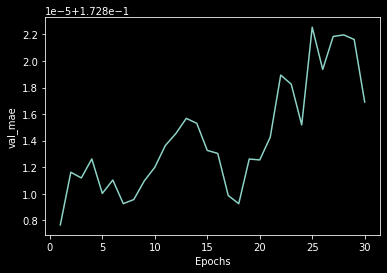

In [57]:
plt.plot(range(1, len(average_mae_history[:30]) + 1), average_mae_history[:30])
plt.xlabel('Epochs')
plt.ylabel('val_mae')
plt.show()

In [55]:
def smooth_curve(points, factor =0.9):
    
    smoothed_points = []
    
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
        
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history)

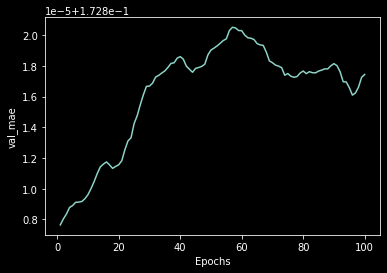

In [56]:
# Difficult to understand plot due to scaling issues
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('val_mae')
plt.show()